In [ ]:
!pip install kymatio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 2.8 MB/s eta 0:00:00


In [96]:
!pip install torchsummary

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Input, Lambda
from keras.utils import to_categorical
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pywt

In [80]:
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
from scipy import io as sio
import imageio						# Load the library
import cv2
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import gridspec
from kymatio import Scattering2D
import os
from sklearn import metrics as sklearn_metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import sys
from tqdm import tqdm
from tensorflow.keras import layers, models , optimizers , losses ,activations , callbacks, metrics
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications import vgg16
from kymatio.torch import Scattering2D

In [97]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision.datasets import ImageFolder

In [82]:
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [83]:
haar = pywt.Wavelet('haar')

In [84]:
haar

pywt._extensions._pywt.Wavelet(name='haar', filter_bank=([0.7071067811865476, 0.7071067811865476], [-0.7071067811865476, 0.7071067811865476], [0.7071067811865476, 0.7071067811865476], [0.7071067811865476, -0.7071067811865476]))

In [85]:
print(haar)

Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [86]:
import os
import random
import numpy as np
import cv2

class EarTripletGenerator:
    def __init__(self, datasetPath):
        self.personDict = self.generate_person_dictionary(datasetPath)

    def generate_person_dictionary(self, datasetPath):
        personDict = {}
        for filename in os.listdir(datasetPath):
            person_name, image_number = filename.split('_')
            if person_name not in personDict:
                personDict[person_name] = []
            personDict[person_name].append(filename)
        return personDict

    def get_next_element_for_person(self, person_name):
        anchorPhoto = random.choice(self.personDict[person_name])

        # Make sure the anchor image is not selected as positive
        positivePhoto = random.choice(self.personDict[person_name])
        while positivePhoto == anchorPhoto:
            positivePhoto = random.choice(self.personDict[person_name])

        # Select a different person for the negative sample
        negativePerson = random.choice(list(self.personDict.keys()))
        while negativePerson == person_name:
            negativePerson = random.choice(list(self.personDict.keys()))

        # Select a random image from the negative person
        negativePhoto = random.choice(self.personDict[negativePerson])

        # Preprocess images
        anchor_img = cv2.imread(os.path.join(datasetPath, anchorPhoto), 0)
        positive_img = cv2.imread(os.path.join(datasetPath, positivePhoto), 0)
        negative_img = cv2.imread(os.path.join(datasetPath, negativePhoto), 0)

        return anchor_img, positive_img, negative_img

# Example usage
datasetPath = "/content/drive/MyDrive/EE678-Wavelets/Project/ear/ear/processed/221"
ear_generator = EarTripletGenerator(datasetPath)

In [87]:
ear_generator.personDict.keys()

dict_keys(['004', '010', '005', '012', '002', '008', '003', '007', '001', '011', '006', '009', '017', '016', '023', '024', '020', '015', '022', '021', '013', '025', '019', '027', '018', '014', '026', '035', '032', '036', '031', '034', '041', '039', '040', '030', '037', '029', '038', '042', '028', '033', '052', '055', '054', '048', '043', '045', '047', '049', '051', '056', '053', '046', '050', '044', '064', '058', '065', '057', '059', '068', '067', '066', '062', '069', '061', '060', '063', '081', '080', '079', '070', '082', '076', '072', '084', '071', '077', '074', '083', '078', '073', '075', '085', '086', '090', '088', '096', '094', '092', '095', '087', '091', '089', '093', '107', '100', '101', '104', '105', '102', '109', '098', '099', '106', '097', '108', '103', '110', '117', '123', '114', '120', '115', '118', '122', '116', '124', '112', '121', '113', '111', '119', '134', '128', '129', '130', '125', '131', '135', '136', '132', '133', '126', '127', '137', '147', '143', '141', '138', '1

In [88]:
#Choose a specific number of keys to use for training data
num_keys_for_training = 200 # You can set this to your desired number
training_data = []

selected_keys = random.sample(list(ear_generator.personDict.keys()), num_keys_for_training)
anchor_images = []
positive_images = []
negative_images = []
for person in selected_keys:
    anchor_img, positive_img, negative_img = ear_generator.get_next_element_for_person(person)
    # Assuming shearlet_transform is a function you have defined for your preprocessing
    # Assuming anchor_images[0] is the image data
    anchor_images.append(anchor_img)
    positive_images.append(positive_img)
    negative_images.append(negative_img)
    # training_data.append([shearlet_transform(anchor_img), shearlet_transform(positive_img), shearlet_transform(negative_img)])

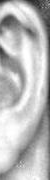

In [89]:
cv2_imshow(anchor_images[0])

In [90]:
save_path = '/content/drive/MyDrive/ear_training_data.npz'
np.savez(save_path, anchor=anchor_images, positive=positive_images, negative=negative_images)

In [91]:
save_path = '/content/drive/MyDrive/ear_training_data.npz'
loaded_data = np.load(save_path)
loaded_anchor_images = loaded_data['anchor']
loaded_positive_images = loaded_data['positive']
loaded_negative_images = loaded_data['negative']

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


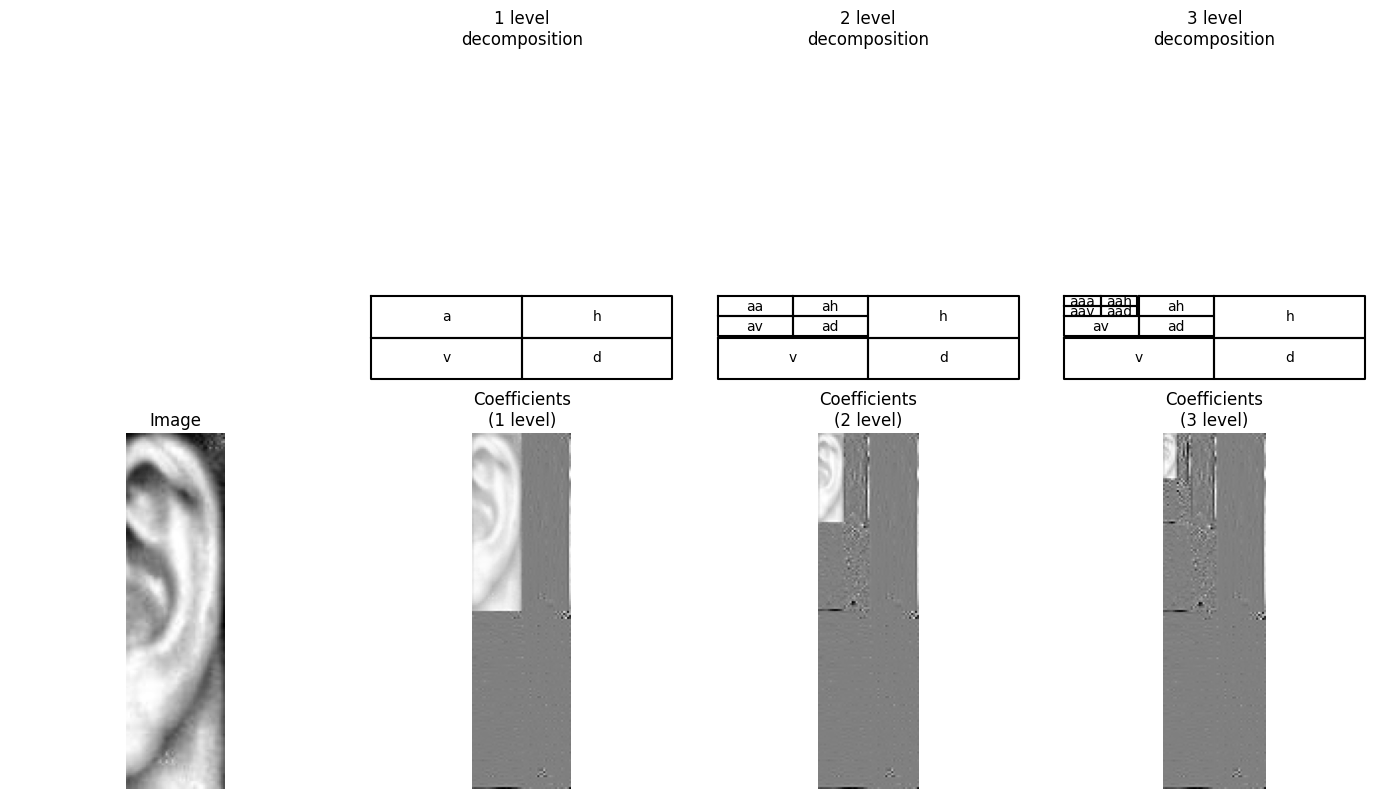

In [99]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

x1 = loaded_anchor_images[0]
# x1 = fingerprint_enhancer.enhance_Fingerprint(x1)
# x1 = cv2.resize(x1, (320, 320))
shape = x1.shape

max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 4, figsize=[14, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x1, cmap=plt.cm.gray)
        axes[1, 0].set_title('Image')
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    # compute the 2D DWT
    c1 = pywt.wavedec2(x1, 'bior4.4', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c1[0] /= np.abs(c1[0]).max()
    for detail_level in range(level):
        c1[detail_level + 1] = [d/np.abs(d).max() for d in c1[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c1)
    axes[1, level].imshow(arr, cmap=plt.cm.gray)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()

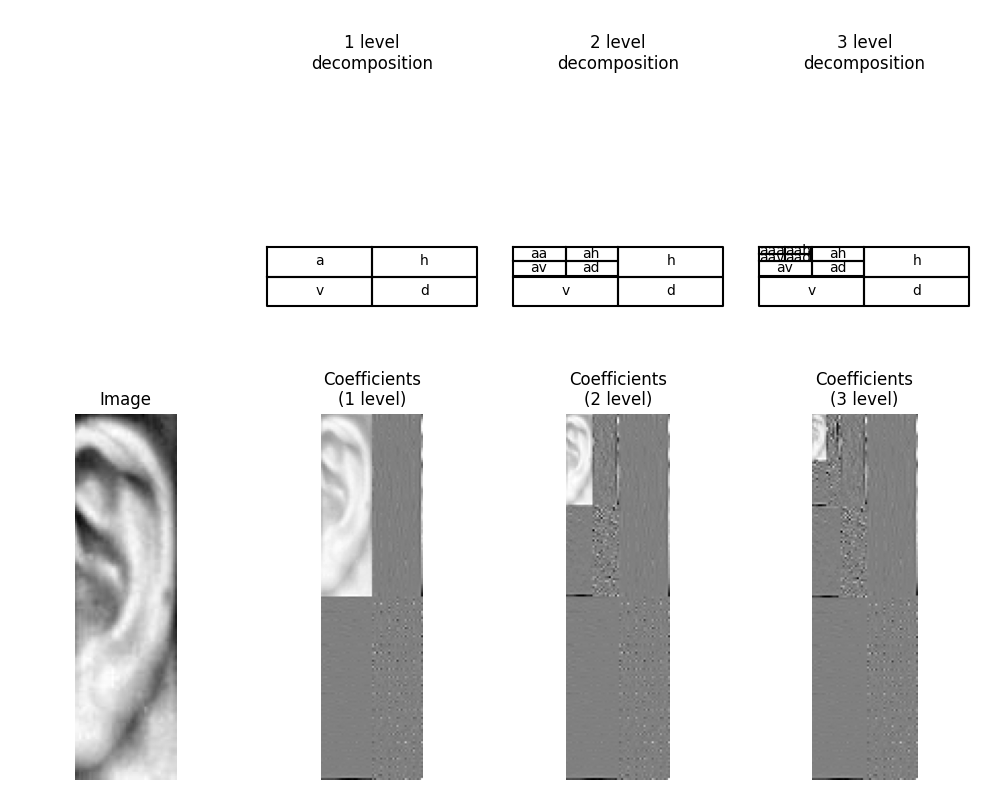

In [93]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

x2 = loaded_positive_images[0]
# x2 = cv2.resize(x2, (320, 320))
shape = x2.shape

max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 4, figsize=[10, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x2, cmap=plt.cm.gray)
        axes[1, 0].set_title('Image')
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    # compute the 2D DWT
    c2 = pywt.wavedec2(x2, 'bior4.4', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c2[0] /= np.abs(c2[0]).max()
    for detail_level in range(level):
        c2[detail_level + 1] = [d/np.abs(d).max() for d in c2[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c2)
    axes[1, level].imshow(arr, cmap=plt.cm.gray)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()

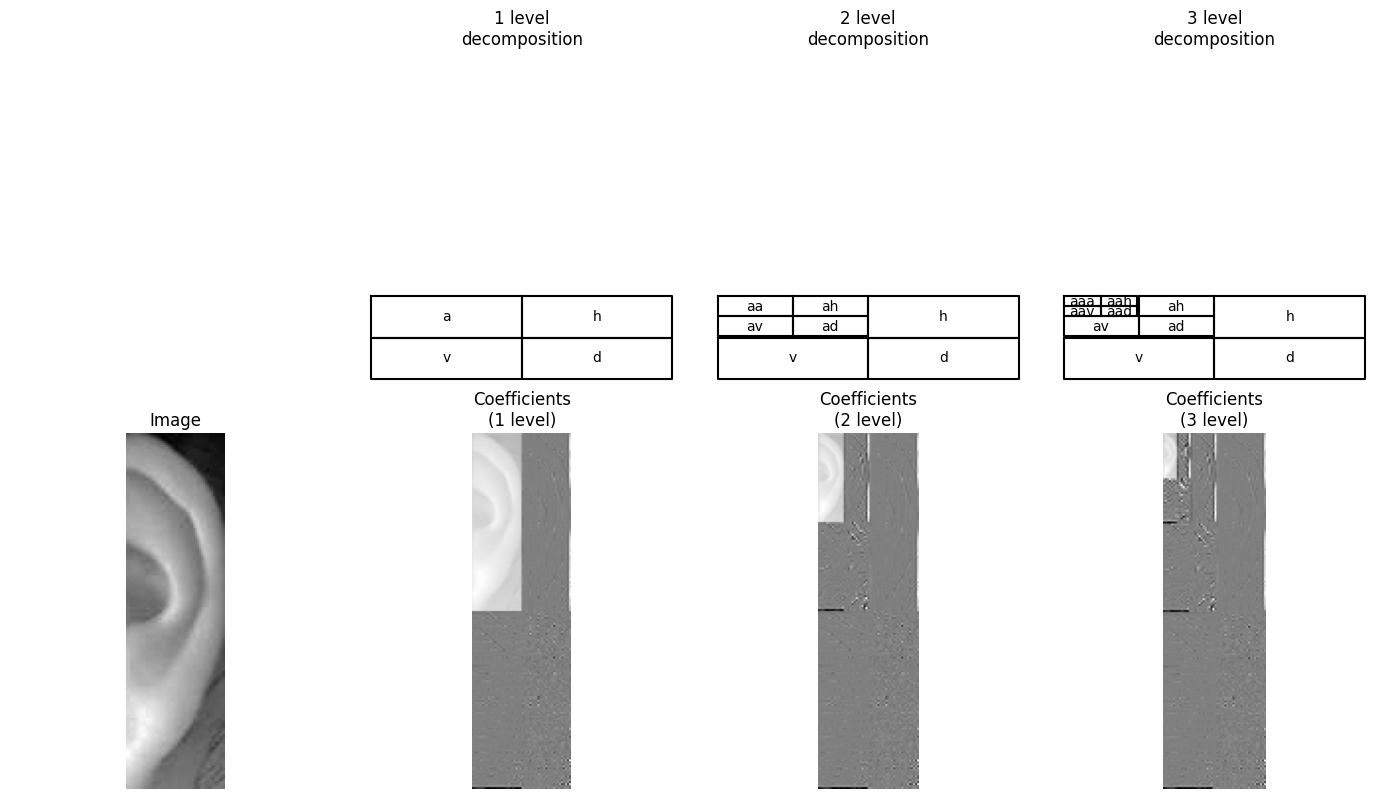

In [94]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

x3 = loaded_negative_images[0]
# x1 = fingerprint_enhancer.enhance_Fingerprint(x1)
# x1 = cv2.resize(x1, (320, 320))
shape = x3.shape

max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 4, figsize=[14, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x3, cmap=plt.cm.gray)
        axes[1, 0].set_title('Image')
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    # compute the 2D DWT
    c3 = pywt.wavedec2(x3, 'bior4.4', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
    c3[0] /= np.abs(c3[0]).max()
    for detail_level in range(level):
        c3[detail_level + 1] = [d/np.abs(d).max() for d in c3[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c3)
    axes[1, level].imshow(arr, cmap=plt.cm.gray)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Reshape matrices to vectors
vector1 = c1[0].flatten()
vector2 = c2[0].flatten()

# Calculate cosine similarity
similarity = np.mean(cosine_similarity([vector1], [vector2]))

print(f"Cosine Similarity: {similarity}")

Cosine Similarity: 0.989967569952211


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Reshape matrices to vectors
vector1 = c1[0].flatten()
vector2 = c3[0].flatten()

# Calculate cosine similarity
similarity = np.mean(cosine_similarity([vector1], [vector2]))

print(f"Cosine Similarity: {similarity}")

Cosine Similarity: 0.9802545272396971


The similarity scores for similar and dissimilar images using Haar decomposition are too close and cannot be distinguished using simple thresholding

In [ ]:
loaded_anchor_images = np.resize(loaded_anchor_images,(200,1,180,50))
loaded_positive_images = np.resize(loaded_positive_images,(200,1,180,50))
loaded_negative_images = np.resize(loaded_negative_images,(200,1,180,50))

In [ ]:
loaded_anchor_images.shape

(200, 180, 50)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader,random_split

class TripletDataset(Dataset):
    def __init__(self, anchor_images, positive_images, negative_images,shape = (320,320), transform=None):
        self.anchor_images = anchor_images
        self.positive_images = positive_images
        self.negative_images = negative_images
        self.transform = transform

    def __len__(self):
        return len(self.anchor_images)

    def __getitem__(self, idx):
        anchor = self.anchor_images[idx]
        positive = self.positive_images[idx]
        negative = self.negative_images[idx]

        # Apply transformations if provided
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

# Assuming loaded_anchor_images, loaded_positive_images, loaded_negative_images are lists of image data
# Make sure each list has the same length

# # Create a TripletDataset
# transform = transforms.Compose([transforms.ToTensor()])  # Add your custom transformations
# triplet_dataset = TripletDataset(loaded_anchor_images, loaded_positive_images, loaded_negative_images, transform)

In [ ]:
scattering = Scattering2D(J = 4,L = 6,max_order = 1,shape=(180, 50))
anchor_scattering = scattering(torch.from_numpy(loaded_anchor_images/255.0).float())
positive_scattering = scattering(torch.from_numpy(loaded_positive_images/255.0).float())
negative_scattering = scattering(torch.from_numpy(loaded_negative_images/255.0).float())

In [ ]:
shape = anchor_scattering.shape
anchor_scattering = np.reshape(anchor_scattering,(shape[0],shape[1]*shape[2],shape[3],shape[4]))
positive_scattering = np.reshape(positive_scattering,(shape[0],shape[1]*shape[2],shape[3],shape[4]))
negative_scattering = np.reshape(negative_scattering,(shape[0],shape[1]*shape[2],shape[3],shape[4]))

In [ ]:
img1 = np.array(anchor_scattering[0])
img2 = np.array(negative_scattering[0])

In [ ]:
img1.shape

(25, 11, 3)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.bn1 = nn.BatchNorm2d(24)
        # self.conv1 = nn.Conv2d(32, 64, kernel_size=3, stride=1)# 28,38
        # self.bn2 = nn.BatchNorm2d(64)
        # self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1)# 26,36
        # self.bn3 = nn.BatchNorm2d(128)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)# 13,18
        self.fc1 = nn.Linear(24 * 11 * 3, 256)
        # self.fc2 = nn.Linear(1028, 512)

    def forward(self, x):
        # x = F.relu(self.bn2(self.conv1(self.bn1(x))))
        # x = F.relu(self.bn3(self.conv2(x)))
        # x = self.pool(x)
        x = self.bn1(x)
        x = x.view(-1, 24 * 11 * 3)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)
        return x

class TripletNet(nn.Module):
    def __init__(self, embedding_model):
        super(TripletNet, self).__init__()
        self.embedding_model = embedding_model

    def forward(self, anchor, positive, negative):
        output_anchor = self.embedding_model(anchor)
        output_positive = self.embedding_model(positive)
        output_negative = self.embedding_model(negative)
        return output_anchor, output_positive, output_negative

# Example usage:
embedding_model = EmbeddingModel()
triplet_net = TripletNet(embedding_model)
optimizer = optim.Adam(triplet_net.parameters(), lr=0.01)

In [98]:
hwidth = 11
wwidth = 3
# Print the summary
result = summary(triplet_net, [(24, hwidth, wwidth), (24, hwidth, wwidth), (24, hwidth, wwidth)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 24, 11, 3]              48
            Linear-2                  [-1, 256]         203,008
    EmbeddingModel-3                  [-1, 256]               0
       BatchNorm2d-4            [-1, 24, 11, 3]              48
            Linear-5                  [-1, 256]         203,008
    EmbeddingModel-6                  [-1, 256]               0
       BatchNorm2d-7            [-1, 24, 11, 3]              48
            Linear-8                  [-1, 256]         203,008
    EmbeddingModel-9                  [-1, 256]               0
Total params: 609,168
Trainable params: 609,168
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1895.12
Forward/backward pass size (MB): 0.03
Params size (MB): 2.32
Estimated Total Size (MB): 1897.47
-------------------------------------

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])  # Add your custom transformations
triplet_dataset = TripletDataset(anchor_scattering[:,1:,:,:], positive_scattering[:,1:,:,:], negative_scattering[:,1:,:,:], transform)
train_size = int(0.7 * 200)
val_size = int(0.15 * 200)
test_size = len(triplet_dataset) - train_size - val_size

# Use random_split to split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(triplet_dataset, [train_size, val_size, test_size])

# Define data loaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
# Now you can use this dataloader in your training loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you have a function to calculate accuracy
def calculate_accuracy(output_anchor, output_positive, output_negative):
    pos_dist = (output_anchor - output_positive).pow(2).sum(1)
    neg_dist = (output_anchor - output_negative).pow(2).sum(1)

    # If positive distance is smaller than negative distance, it's a correct match
    correct_matches = (pos_dist < neg_dist).float().sum()

    # Calculate accuracy as the ratio of correct matches to the total number of samples
    accuracy = correct_matches / len(output_anchor)

    return accuracy.item()

num_epochs = 5
train_accuracies = []
val_accuracies = []
train_losses = []
triplet_net.train()

# Assuming you have train_dataloader and val_dataloader for training and validation
for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0

    # Training phase
    triplet_net.train()
    for batch in train_dataloader:
        anchor, positive, negative = batch
        optimizer.zero_grad()
        output_anchor, output_positive, output_negative = triplet_net(anchor, positive, negative)

        # Assuming you have a triplet loss implementation
        margin = 10.0
        triplet_margin_loss = nn.TripletMarginLoss(margin=margin)

        # Calculate the loss
        loss = triplet_margin_loss(output_anchor, output_positive, output_negative)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        accuracy = calculate_accuracy(output_anchor, output_positive, output_negative)
        total_accuracy += accuracy
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    average_accuracy = total_accuracy / len(train_dataloader)
    train_accuracies.append(average_accuracy)
    train_losses.append(average_loss)

    # Validation phase
    triplet_net.eval()
    total_val_accuracy = 0.0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_anchor, val_positive, val_negative = val_batch
            val_output_anchor, val_output_positive, val_output_negative = triplet_net(val_anchor, val_positive, val_negative)

            # Calculate validation accuracy
            val_accuracy = calculate_accuracy(val_output_anchor, val_output_positive, val_output_negative)
            total_val_accuracy += val_accuracy

    average_val_accuracy = total_val_accuracy / len(val_dataloader)
    val_accuracies.append(average_val_accuracy)


    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Accuracy: {average_accuracy}, Val Accuracy: {average_val_accuracy}')


Epoch 1/5, Loss: 0.9584794905450609, Accuracy: 0.9722222222222222, Val Accuracy: 0.96875
Epoch 2/5, Loss: 0.5277403460608588, Accuracy: 0.9722222222222222, Val Accuracy: 0.96875
Epoch 3/5, Loss: 0.07509418328603108, Accuracy: 0.9930555555555556, Val Accuracy: 0.96875
Epoch 4/5, Loss: 0.0, Accuracy: 1.0, Val Accuracy: 1.0
Epoch 5/5, Loss: 0.01730733447604709, Accuracy: 1.0, Val Accuracy: 0.9375


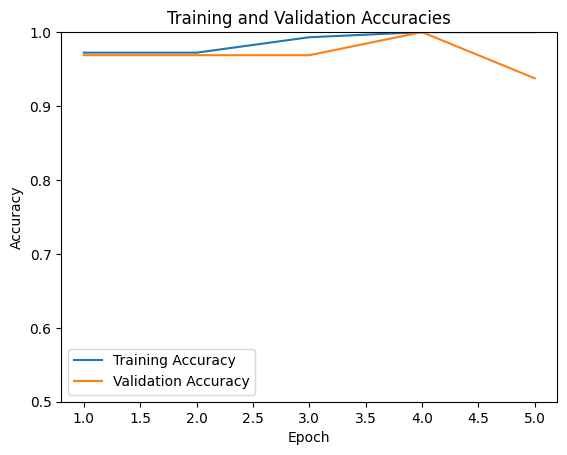

In [ ]:
# Plotting the training and validation accuracies
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

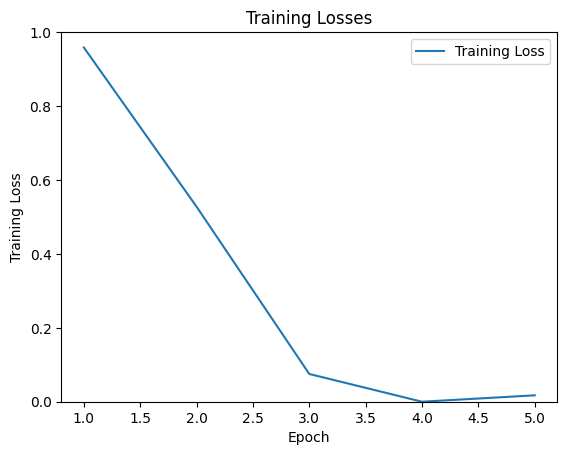

In [ ]:
# Plotting the training and validation accuracies
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Losses')
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a test_dataloader for testing
# Modify this based on your actual dataset and model

# Set the model to evaluation mode
triplet_net.eval()

# Lists to store anchor, positive, and negative distances
all_positive_distances = []
all_negative_distances = []
predictions = []

# Iterate over the test dataset
with torch.no_grad():
    for test_batch in test_dataloader:
        test_anchor, test_positive, test_negative = test_batch

        # Get embeddings from the model
        anchor_embedding = embedding_model(test_anchor)
        positive_embedding = embedding_model(test_positive)
        negative_embedding = embedding_model(test_negative)

        # Calculate distances
        positive_distance = torch.sum((anchor_embedding - positive_embedding).pow(2), dim=1)
        negative_distance = torch.sum((anchor_embedding - negative_embedding).pow(2), dim=1)

        # Append distances to the lists
        predictions.append((positive_distance < negative_distance))
        all_positive_distances.extend(positive_distance.cpu().numpy())
        all_negative_distances.extend(negative_distance.cpu().numpy())

# Convert lists to PyTorch tensors
all_positive_distances = torch.tensor(all_positive_distances)
all_negative_distances = torch.tensor(all_negative_distances)

# Calculate accuracy based on distances
# print(all_positive_distances)
# print(all_negative_distances)
correct_matches = (all_positive_distances < all_negative_distances).sum().item()
total_samples = len(all_positive_distances)
accuracy = correct_matches / total_samples

print(f'Test Accuracy: {accuracy*100 :.5f}%')

Test Accuracy: 100.00000%


In [ ]:
img2 = np.array(loaded_anchor_images[0].reshape(180,50))
img1 = np.array(loaded_positive_images[0].reshape(180,50))
img3 = np.array(loaded_negative_images[0].reshape(180,50))
stacked_img = np.hstack((img1, img2, img3))

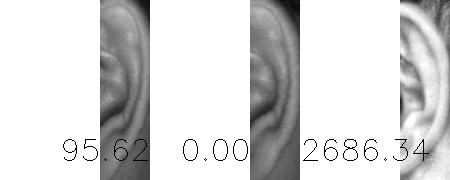

In [ ]:
import cv2

# Ensure all images have the same height
height = min(img1.shape[0], img2.shape[0], img3.shape[0])

# Resize images to have the same height
img1 = cv2.resize(img1, (int(img1.shape[1] * height / img1.shape[0]), height))
img2 = cv2.resize(img2, (int(img2.shape[1] * height / img2.shape[0]), height))
img3 = cv2.resize(img3, (int(img3.shape[1] * height / img3.shape[0]), height))

# Stack images horizontally
stacked_img = np.hstack((255*np.ones((180,100)),img1,255*np.ones((180,100)), img2,255*np.ones((180,100)), img3))

# Add labels to the stacked image
label1 = f'{positive_distance[0]:.2f}'
label2 = f'0.00'  # Assuming anchor distance is always 0
label3 = f'{negative_distance[0]:.2f}'

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 1
font_color = (0, 0, 255)  # White color

cv2.putText(stacked_img, label1, (60, height - 20), font, font_scale, font_color, font_thickness)
cv2.putText(stacked_img, label2, (img1.shape[1] + 130, height - 20), font, font_scale, font_color, font_thickness)
cv2.putText(stacked_img, label3, (img1.shape[1] + img2.shape[1] + 200, height - 20), font, font_scale, font_color, font_thickness)

# Display the stacked and labeled image
cv2_imshow(stacked_img)